In [1]:
import sys 
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u

In [5]:
%load_ext autoreload
%autoreload 2
from database import Magneticum

In [26]:
class Distribution:

    def __init__(self,grid:float,snap:str,box:str='') -> None:
        self.grid = (grid * u.Mpc).to('kpc')
        self._grid_ = self.grid.value
        self.h = 0.7
        self.dataframe_clu = Magneticum(snap,box,'cluster').dataframe
        self.dataframe_gal = Magneticum(snap,box,'galaxies').dataframe
        self.dataframe = self.calculate()
    
    def __modify_dataframe_cluster__(self):
        dataframe = pd.DataFrame.from_dict({'x':self.dataframe_clu['x[kpc/h]']/self.h,
                                            'y':self.dataframe_clu['y[kpc/h]']/self.h,
                                            'z':self.dataframe_clu['z[kpc/h]']/self.h,})
        #dataframe['m500c[Msol]'] = self.dataframe_clu['m500c[Msol/h]']/self.h
        dataframe['Veff'] = np.sqrt(self.dataframe_clu['vx[km/s]']**2 + self.dataframe_clu['vy[km/s]']**2 + self.dataframe_clu['vz[km/s]']**2)
        return dataframe

    def __modify_dataframe_galaxies__(self):
        dataframe = pd.DataFrame.from_dict({'x':self.dataframe_gal['x[kpc/h]']/self.h,
                                            'y':self.dataframe_gal['y[kpc/h]']/self.h,
                                            'z':self.dataframe_gal['z[kpc/h]']/self.h,})
        return dataframe
    
    def calculate_cube_indices(self, dataframe):
        cube_size = self.grid.value
        min_x, max_x = dataframe['x'].min(), dataframe['x'].max()
        min_y, max_y = dataframe['y'].min(), dataframe['y'].max()
        min_z, max_z = dataframe['z'].min(), dataframe['z'].max()
        num_cubes_x = int(np.ceil((max_x - min_x) / cube_size))
        num_cubes_y = int(np.ceil((max_y - min_y) / cube_size))
        num_cubes_z = int(np.ceil((max_z - min_z) / cube_size))

        def assign_cube_ids(df):
            df['cube_x'] = np.floor((df['x'] - min_x) / cube_size).astype(int)
            df['cube_y'] = np.floor((df['y'] - min_y) / cube_size).astype(int)
            df['cube_z'] = np.floor((df['z'] - min_z) / cube_size).astype(int)
            df['cube_id'] = (df['cube_x'] * num_cubes_y * num_cubes_z +
                            df['cube_y'] * num_cubes_z +
                            df['cube_z'])
            return df
        
        dataframe = assign_cube_ids(dataframe)
        return dataframe, num_cubes_x, num_cubes_y, num_cubes_z
    
    def add_cluster_ratio(self, dataframe):
        clusters_per_cube = dataframe.groupby('cube_id').size().reset_index(name='num_clusters')
        mean_num_clusters = clusters_per_cube['num_clusters'].mean()
        clusters_per_cube['cluster_number_ratio'] = clusters_per_cube['num_clusters'] / mean_num_clusters
        dataframe = dataframe.merge(clusters_per_cube[['cube_id', 'cluster_number_ratio']], on='cube_id', how='left')
        return dataframe
    
    def add_cluster_density(self, dataframe):
        clusters_per_cube = dataframe.groupby('cube_id').size().reset_index(name='num_clusters')
        mean_num_clusters = clusters_per_cube['num_clusters'].mean()
        clusters_per_cube['cluster_number_density'] = (clusters_per_cube['num_clusters'] - mean_num_clusters)/ mean_num_clusters
        dataframe = dataframe.merge(clusters_per_cube[['cube_id', 'cluster_number_density']], on='cube_id', how='left')
        return dataframe

    def add_galaxy_ratio(self, dataframe, galaxy_dataframe):
        galaxies_per_cube = galaxy_dataframe.groupby('cube_id').size().reset_index(name='num_galaxies')
        mean_num_galaxies = galaxies_per_cube['num_galaxies'].mean()
        galaxies_per_cube['galaxy_number_ratio'] = galaxies_per_cube['num_galaxies'] / mean_num_galaxies
        dataframe = dataframe.merge(galaxies_per_cube[['cube_id', 'galaxy_number_ratio']], on='cube_id', how='left')
        return dataframe
    
    def add_galaxy_density(self, dataframe, galaxy_dataframe):
        galaxies_per_cube = galaxy_dataframe.groupby('cube_id').size().reset_index(name='num_galaxies')
        mean_num_galaxies = galaxies_per_cube['num_galaxies'].mean()
        galaxies_per_cube['galaxy_number_density'] = (galaxies_per_cube['num_galaxies'] - mean_num_galaxies)/ mean_num_galaxies
        dataframe = dataframe.merge(galaxies_per_cube[['cube_id', 'galaxy_number_density']], on='cube_id', how='left')
        return dataframe
    
    def add_velocity_gradient(self, dataframe, galaxy_dataframe):
        galaxies_per_cube = galaxy_dataframe.groupby('cube_id').size().reset_index(name='num_galaxies')
        mean_num_galaxies = galaxies_per_cube['num_galaxies'].mean()
        dg = (galaxies_per_cube['num_galaxies'] - mean_num_galaxies)/ mean_num_galaxies
        k = np.fft.fftfreq(len(dg))
        dg_k = np.fft.fft(dg)
        R =(15 * u.Mpc).to('kpc')
        kernel = np.exp(-R.value**2 * k**2 / 2)
        dg_k *= kernel
        inte = 1j * dg_k / k
        inte[k==0] = 0
        s = np.abs(np.fft.ifft(inte))
        galaxies_per_cube['Vg'] = s
        dataframe = dataframe.merge(galaxies_per_cube[['cube_id', 'Vg']], on='cube_id', how='left')
        return dataframe

    def calculate(self):
        data = self.__modify_dataframe_cluster__()
        data1 = self.__modify_dataframe_galaxies__()
        data, num_cubes_x, num_cubes_y, num_cubes_z = self.calculate_cube_indices(data)
        data1 = self.calculate_cube_indices(data1)[0]

        data = self.add_cluster_density(data)
        data = self.add_velocity_gradient(data, data1)
        
        data = data.drop(['cube_x', 'cube_y', 'cube_z', 'cube_id'], axis=1)

        return data

In [27]:
d2 = Distribution(10,'022','b')

/tmp/ipykernel_3302857/2702348989.py:83: RuntimeWarning: divide by zero encountered in true_divide
  inte = 1j * dg_k / k


In [29]:
d2.dataframe

,x,y,z,Veff,cluster_number_density,Vg
0,331668.485714,632168.971429,645139.057143,366.954756,-0.132055,20051.772153
1,255348.571429,616694.328571,618932.728571,502.538950,-0.132055,574.506470
2,78788.437143,650603.300000,908410.714286,178.124915,-0.132055,5198.112454
3,780125.985714,453116.557143,461240.671429,431.962604,-0.132055,11902.558592
4,653411.428571,314633.085714,399264.285714,358.730607,0.735890,10862.853900
...,...,...,...,...,...,...
42023,432932.857143,702466.157143,272588.400000,401.707695,0.735890,24714.146219
42024,852456.514286,721343.128571,742103.571429,603.670443,-0.132055,21889.204713
42025,610825.271429,669634.242857,114618.024286,507.285362,1.603836,3477.863568
42026,381813.028571,306233.614286,668153.342857,336.366795,-0.132055,24179.846015


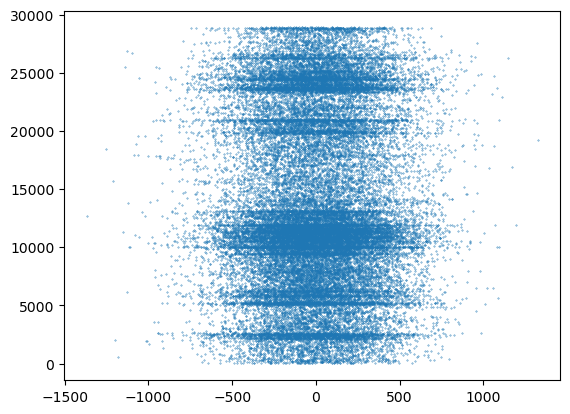

In [30]:
plt.scatter(d2.dataframe_clu['vz[km/s]'], d2.dataframe['Vg'], s=0.1)

In [49]:
np.corrcoef(d2.dataframe_clu['vz[km/s]'],np.abs(d2.dataframe_clu['vz[km/s]']) )

array([[ 1.        , -0.00602472],
       [-0.00602472,  1.        ]])

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
regr2 = RandomForestRegressor(max_depth=50, random_state=0,n_jobs=-1,max_leaf_nodes=2)

In [44]:
def get_inp(features):
    xlen = len(features[0])
    ylen = len(features)
    inp = np.zeros((xlen,ylen))
    for i in range(len(features)):
        inp[:,i] = features[i]
    return inp

In [45]:
fx = d2.dataframe_clu['vz[km/s]']
x =  get_inp([d2.dataframe['Vg']])

In [50]:
regr2.fit(x, fx)

RandomForestRegressor(max_depth=50, max_leaf_nodes=2, n_jobs=-1, random_state=0)

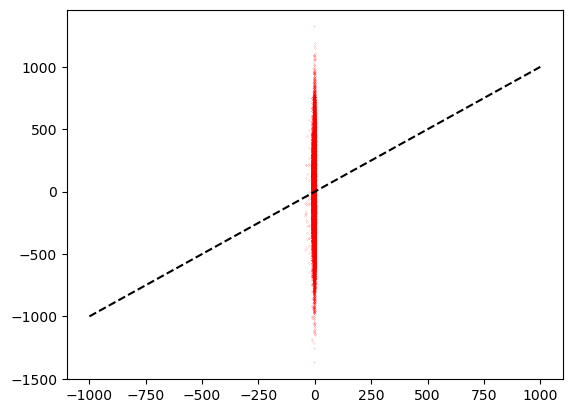

In [51]:
plt.plot(regr2.predict(x),fx, 'o', color='red', markersize=0.1)
plt.plot([-1000,1000.],[-1000.,1000],'k--')

In [52]:
42*500

21000